In [13]:
!pip install -q ultralytics supervision gdown

In [14]:
!pip install pytube openai

In [15]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [16]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Video processing

In [41]:
from pytube import YouTube
import os

import cv2
import math
import json
import copy
import base64
import requests

import numpy as np
import pandas as pd
import supervision as sv

from tqdm.notebook import tqdm
from ultralytics import YOLO
from typing import List, Optional, Dict, Iterator, Tuple

In [42]:
path = '/content/Grassroot_data_15.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,Date,Title,URLs,Views,Is_Video,Video_ID,Video_Duration,Duration_Minutes
0,VM513:1,30/01/2024,U23 GetScouted Showcase Match Footage | London...,https://www.youtube.com/watch?v=8ZabZYk8tBg&t=...,1162.0,True,8ZabZYk8tBg,PT1H7M12S,67.200000
1,VM513:1,30/01/2024,TALENT ID MATCH - GETSCOUTED ELITE V MUNDI GEN...,https://www.youtube.com/watch?v=OPddmoSOwsk,526.0,True,OPddmoSOwsk,PT1H30M37S,90.616667
2,VM513:1,30/01/2024,(GetScouted Webinar) What does it take to get ...,https://www.youtube.com/watch?v=2muV6yWpF1A,227.0,True,2muV6yWpF1A,PT49M48S,49.800000
3,VM644:1,30/01/2024,A LATE FREE KICK GOLAZO! | LONDON LEGACY VS TI...,https://www.youtube.com/watch?v=PNuf6akaVAE,207.0,True,PNuf6akaVAE,PT1H34M33S,94.550000
4,VM644:1,30/01/2024,OUTPLAYED ON HOME TURF! | LEGACY VS AC MILANO ...,https://www.youtube.com/watch?v=yRLWlLB4-fo,215.0,True,yRLWlLB4-fo,PT1H33M7S,93.116667
...,...,...,...,...,...,...,...,...,...
584,VM607:1,30/01/2024,La Roca HW vs Omni-U8 Indoor soccer 11-29-14,https://www.youtube.com/watch?v=UIE7-CW-ukk,649.0,True,UIE7-CW-ukk,PT15M28S,15.466667
585,VM607:1,30/01/2024,La Roca RH vs XBOX-U8 Indoor Soccer 11-22-14,https://www.youtube.com/watch?v=M3Gl3UjKBlc,1554.0,True,M3Gl3UjKBlc,PT16M36S,16.600000
586,VM607:1,30/01/2024,La Roca HW vs Outlaws BY-U8 Indoor Soccer 11-1...,https://www.youtube.com/watch?v=YhGj2voXjes,1988.0,True,YhGj2voXjes,PT15M42S,15.700000
587,VM607:1,30/01/2024,La Roca RH vs United-U8 Indoor Soccer 11-15-14,https://www.youtube.com/watch?v=6m8WoDyjrMk,497.0,True,6m8WoDyjrMk,PT18M14S,18.233333


In [19]:
random_indices = np.random.randint(0, df.shape[0], size=5)
data_download = df.iloc[random_indices]
data_download

,Unnamed: 0,Date,Title,URLs,Views,Is_Video,Video_ID,Video_Duration,Duration_Minutes
227,VM607:1,30/01/2024,MetaSport BT vs La Roca TC - U13 Premier Soccer,https://www.youtube.com/watch?v=cbQ57y5OcLc,5921.0,True,cbQ57y5OcLc,PT22M39S,22.650000
369,VM607:1,30/01/2024,Sparta Cup-USA JH vs Wasatch JS-U12 Tournament...,https://www.youtube.com/watch?v=VNr0VA2XNAY,45490.0,True,VNr0VA2XNAY,PT20M17S,20.283333
140,VM607:1,30/01/2024,Rush FC vs La Roca AV - U16 Tournament Soccer,https://www.youtube.com/watch?v=9BYZpbrU7fk,4695.0,True,9BYZpbrU7fk,PT22M20S,22.333333
367,VM607:1,30/01/2024,Sparta Cup-Sparta SP vs Wasatch JS-U12 Tournam...,https://www.youtube.com/watch?v=BKDB132Oqn8,79560.0,True,BKDB132Oqn8,PT27M35S,27.583333
168,VM607:1,30/01/2024,Utah State Cup - U15 Championship,https://www.youtube.com/watch?v=BaIfUHSmS14,12815.0,True,BaIfUHSmS14,PT33M13S,33.216667


In [20]:
def download_videos(data, url_column, download_path='.'):
    """
    Download YouTube videos from URLs contained in a DataFrame.

    Args:
    data (pd.DataFrame): The DataFrame containing the video URLs.
    url_column (str): The name of the column containing the YouTube URLs.
    download_path (str): The path to the directory where videos will be downloaded.

    This function downloads each video to the specified directory.
    """
    # Ensure the download directory exists
    os.makedirs(download_path, exist_ok=True)

    for url in data[url_column]:
        try:
            yt = YouTube(url)

            # Get the first stream; by default pytube selects the first available stream
            video = yt.streams.filter(progressive=True, file_extension='mp4').first()

            if video:
                video.download(download_path)
                print(f"Downloaded {yt.title} successfully.")
            else:
                print(f"No available video stream for {url}.")
        except Exception as e:
            print(f"Failed to download {url}: {str(e)}")




def download_best_available(data, url_column, download_path='.'):
    counter = 1

    for url in data[url_column]:
        try:
            yt = YouTube(url)

            video = yt.streams.filter(progressive=True, file_extension='mp4', res="720p").first()

            if not video:
                video = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()

            if video:
                video.download(output_path=download_path)

                print(f"Downloaded {yt.title} at {video.resolution} successfully")

                counter += 1

            else:
                print(f"No video available for {url}")

        except Exception as e:
            print(f"Failed to download {url}: {str(e)}")


def single_video_download(path="/content", url='https://www.youtube.com/watch?v=zWdNIxytzTM'):
      try:
          yt = YouTube(url)

          video = yt.streams.filter(progressive=True, file_extension='mp4', res="720p").first()

          if not video:
              video = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()

          if video:
              video.download(output_path=path)

              print(f"Downloaded {yt.title} at {video.resolution} successfully")


          else:
              print(f"No video available for {url}")

      except Exception as e:
          print(f"Failed to download {url}: {str(e)}")

def extract_frames(video_path, frames_dir, skip_frames=0):
    """
    Extract frames from a video file.

    Args:
    video_path (str): Path to the video file.
    frames_dir (str): Directory to save the extracted frames.
    skip_frames (int): Number of frames to skip between extractions.
    """
    os.makedirs(frames_dir, exist_ok=True)
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    count = 0

    while success:
        if count % (skip_frames + 1) == 0:
            cv2.imwrite(f"{frames_dir}/frame_{count}.jpg", image)     # save frame as JPEG file
        success, image = vidcap.read()
        count += 1
    print("All frame are collected")


def extract_frames_from_all_videos(videos_dir, frames_root_dir, skip_frames=0):
    """
    Extract frames from all video files in a given directory and save them into separate directories for each video.

    Args:
    videos_dir (str): Path to the directory containing video files.
    frames_root_dir (str): Root directory to save the frames directories for each video.
    skip_frames (int): Number of frames to skip between extractions.
    """
    os.makedirs(frames_root_dir, exist_ok=True)
    video_files = [f for f in os.listdir(videos_dir) if os.path.isfile(os.path.join(videos_dir, f))]

    # Loop over each file in the directory
    for video_file in video_files:
        # Construct the full path to the video file
        video_path = os.path.join(videos_dir, video_file)
        # Create a directory for frames of this video
        video_name = os.path.splitext(video_file)[0]
        frames_dir = os.path.join(frames_root_dir, video_name)
        os.makedirs(frames_dir, exist_ok=True)

        extract_frames(video_path, frames_dir, skip_frames)

In [21]:
single_video_download()

Downloaded Luton 4-0 Brighton | WHAT A NIGHT! 🔥 | Premier League Highlights at 720p successfully


In [ ]:
download_path = '../data/videos'

download_best_available(data_download, 'URLs', download_path)

In [ ]:
videos_dir = '../data/videos'
frames_root_dir = '../data/videos_frames'

extract_frames_from_all_videos(videos_dir, frames_root_dir, skip_frames=0)

All frame are collected
All frame are collected
All frame are collected
All frame are collected
All frame are collected


## Helper function

In [22]:
COLOR_HEX_LIST = [
    "#EE4B2B",
    "#FFFF00",
    "#D3D3D3"
]


def annotate_prompt(
    image: np.ndarray,
    detections: sv.Detections,
    labels: Optional[List[str]] = None
) -> np.ndarray:
    """
    Annotates an image with bounding boxes and labels based on provided detections.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in a format compatible with sv.BoundingBoxAnnotator
            and sv.LabelAnnotator, typically a NumPy array.
        detections (sv.Detections): A collection of detections, each typically containing information like
            bounding box coordinates, class IDs, etc., to be used for annotation.
        labels (Optional[List[str]]): A list of strings representing the labels for each detection. If not
            provided, labels are automatically generated as sequential numbers.

    Returns:
        np.ndarray: An annotated version of the input image, with bounding boxes and labels drawn over it.

    """
    bounding_box_annotator = sv.BoundingBoxAnnotator(
        color=sv.Color.black(),
        color_lookup=sv.ColorLookup.CLASS)
    label_annotator = sv.LabelAnnotator(
        color=sv.Color.black(),
        text_color=sv.Color.white(),
        color_lookup=sv.ColorLookup.CLASS,
        text_scale=0.7)

    if labels is None:
        labels = [str(i) for i in range(len(detections))]

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(
        annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections=detections, labels=labels)

    return annotated_image


def annotate_result(
    image: np.ndarray,
    detections: sv.Detections
) -> np.ndarray:
    """
    Annotates a given image with ellipses around detected objects.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in the format
            acceptable by sv.EllipseAnnotator.
        detections (sv.Detections): An object of sv.Detections, which contains
            the detected objects' information to be annotated on the image.

    Returns:
        np.ndarray: An image (numpy array) with ellipses drawn around the detected
            objects. This image is a modified copy of the input image.
    """
    h, w, _ = image.shape
    text_scale = sv.calculate_dynamic_text_scale(resolution_wh=(w, h))
    text_scale = min(text_scale, 0.8)
    line_thickness = sv.calculate_dynamic_line_thickness(resolution_wh=(w, h))
    ellipse_annotator = sv.EllipseAnnotator(
        color=sv.ColorPalette.from_hex(color_hex_list=COLOR_HEX_LIST),
        color_lookup=sv.ColorLookup.CLASS,
        thickness=line_thickness)
    label_annotator = sv.LabelAnnotator(
        color=sv.ColorPalette.from_hex(color_hex_list=COLOR_HEX_LIST),
        text_color=sv.Color.black(),
        color_lookup=sv.ColorLookup.CLASS,
        text_position=sv.Position.BOTTOM_CENTER,
        text_scale=text_scale)

    labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]

    annotated_image = image.copy()
    annotated_image = ellipse_annotator.annotate(
        annotated_image, detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections, labels=labels)
    return annotated_image

In [23]:
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"


def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode('.jpg', image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {
        "type": "text",
        "text": prompt
    }
    image_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"
            }
        }
        for image
        in images
    ]
    return {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [text_content] + image_content
            }
        ],
        "max_tokens": 300
    }


def compose_headers(api_key: str) -> dict:
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if 'error' in response:
        raise ValueError(response['error']['message'])
    return response['choices'][0]['message']['content']

In [24]:
def resize_images(images: List[np.ndarray], size: Tuple[int, int]) -> List[np.ndarray]:
    """
    Resizes all images to the specified size.

    Args:
        images (List[np.ndarray]): A list of images to be resized. Each image is a 3D NumPy array.
        size (Tuple[int, int]): The target size for the images, specified as (width, height).

    Returns:
        List[np.ndarray]: A list of resized images.
    """
    return [cv2.resize(image, size) for image in images]


def blend_images(images: List[np.ndarray]) -> np.ndarray:
    """
    Blends a list of images into a single image.

    Args:
    images: A list of images where each image is a NumPy array. All images must have the same shape and dtype.

    Returns:
    A blended image as a NumPy array.

    Raises:
    ValueError: If the input list is empty.
    """
    if not images:
        raise ValueError("The list of images is empty.")

    image_stack = np.stack(images)
    blended_image = np.mean(image_stack, axis=0)

    return blended_image.astype(np.uint8)


def chunk_list(lst: List, n: int) -> Iterator[List]:
    """
    Yield successive n-sized chunks from a list.

    Parameters:
        lst (List): The list to be chunked.
        n (int): The size of each chunk.

    Yields:
        Iterator[List]: An iterator over the chunks of the list, each being a list of maximum `n` elements.
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

## Set open-ai API Key

In [ ]:
OPENAI_API_KEY = "your_api_key"

## Load detection model

In [26]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:01<00:00, 115MB/s]


In [27]:
single_video_path = "/content/Luton 4-0 Brighton  WHAT A NIGHT! 🔥  Premier League Highlights.mp4"

sv.VideoInfo.from_video_path(single_video_path)

VideoInfo(width=1280, height=720, fps=29, total_frames=4652)

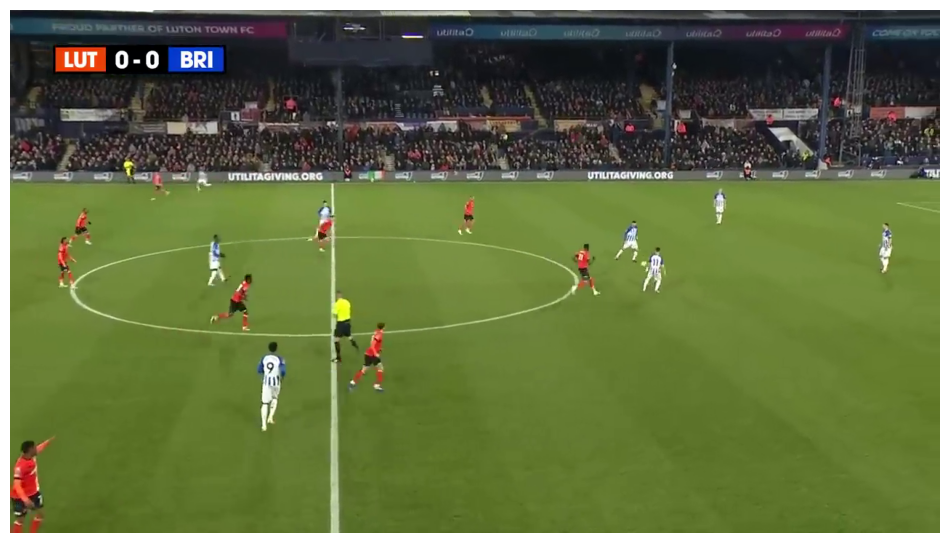

In [28]:
frame_generator = sv.get_video_frames_generator(single_video_path, start=80)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
sv.plot_image(frame)

## Team identification

In [32]:
prompt = (
    "What colors of uniforms are worn by the teams playing in this match? "
    "Return the result in the form of a python list: [, ]. "
    "Replace the values in `<>` with the names of the colors."
    "IMPORTANTLY, do not surround the result with punctuation marks (`). "
    "notalk;justgo"
)
response = prompt_image(api_key=OPENAI_API_KEY, images=[frame], prompt=prompt)
print(response)

["orange", "white"]


In [33]:
type(response)

str

In [34]:
CLASSES = json.loads(response) + ["none"]

## Baseline object detection with YOLO

<ipython-input-22-7f4890e38509>:76: DeprecationWarning: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.BLACK` instead.
  text_color=sv.Color.black(),


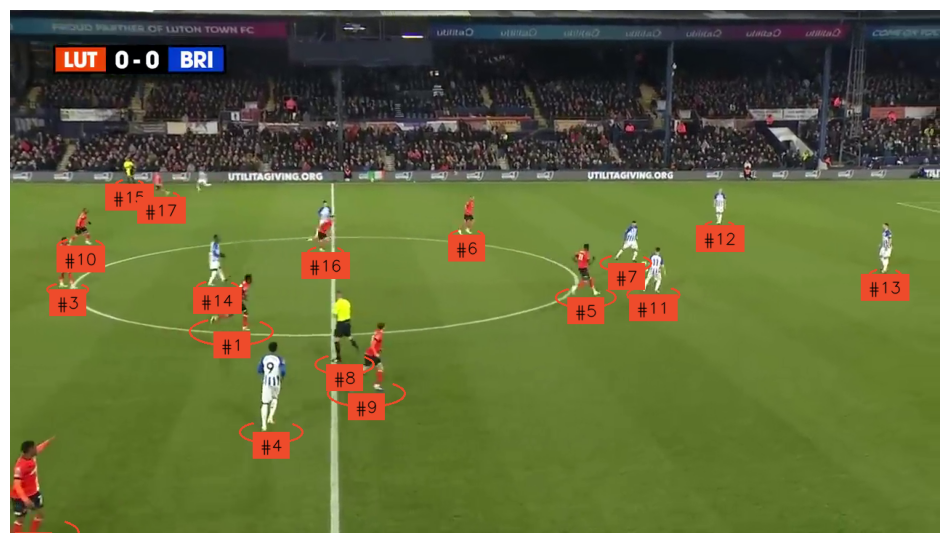

In [35]:
byte_track = sv.ByteTrack()

result = model(frame, imgsz=1280, verbose=False, iou=0.5, conf=0.3)[0]

detections = sv.Detections.from_ultralytics(result)
detections = detections[detections.class_id == 0]
detections = byte_track.update_with_detections(detections=detections)

annotated_frame = annotate_result(image=frame, detections=detections)
sv.plot_image(annotated_frame)

In [36]:
print(detections)

Detections(xyxy=array([[     276.45,      363.12,      333.85,      443.72],
       [      1.034,      584.63,      63.866,      719.31],
       [     65.275,      313.36,      93.118,      385.79],
       [     338.82,      456.23,      381.03,      581.14],
       [     772.07,      322.05,      813.62,      396.22],
       [     617.09,      256.51,       639.5,      310.25],
       [     830.91,      290.55,      865.65,      349.04],
       [     440.28,      385.64,      480.98,      488.35],
       [     464.15,      429.96,       517.4,      528.02],
       [       81.3,      272.79,       112.8,      325.26],
       [     867.52,      326.84,       903.4,      392.11],
       [     967.28,      246.12,      986.72,      297.91],
       [     1194.8,      293.69,      1215.1,      364.31],
       [     271.07,      309.13,      299.27,      382.35],
       [     155.62,       203.2,      173.81,      240.92],
       [      422.2,      262.14,      446.19,      334.33],
       [

In [37]:
len(detections)

17

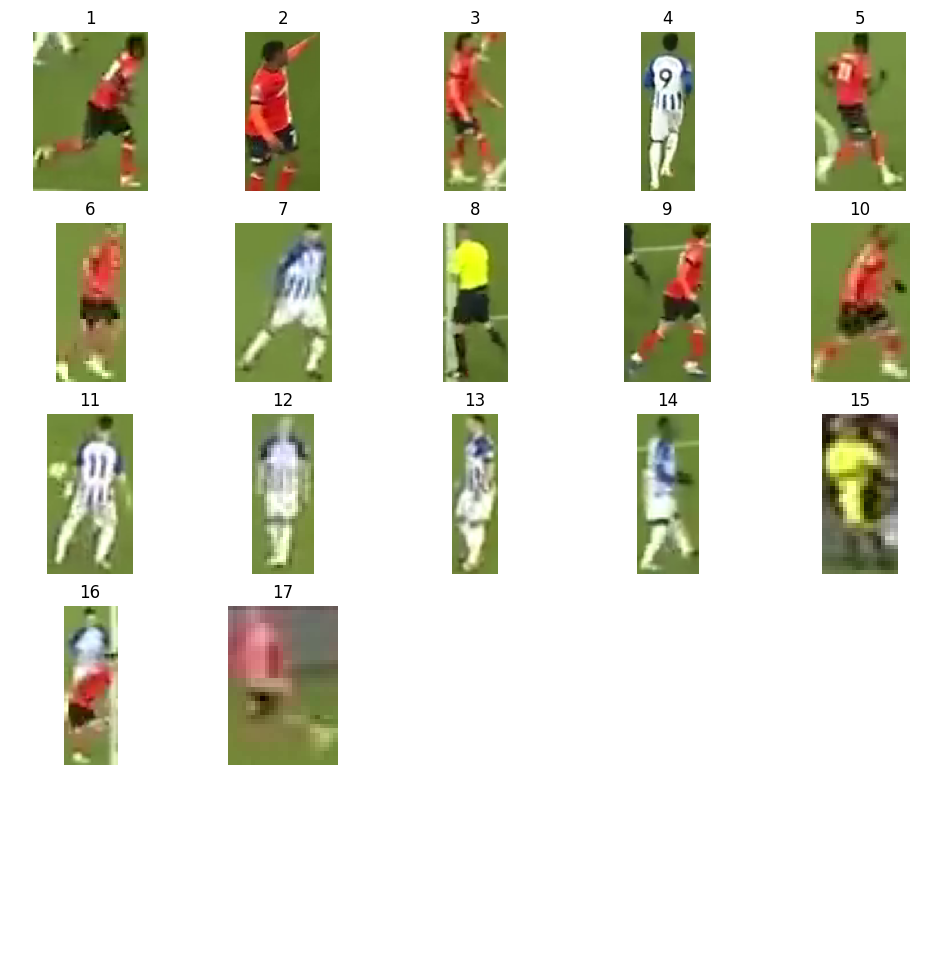

In [38]:
tracker_ids = []
crops = []

for detection in detections:
    xyxy = detection[0]
    mask = detection[1]
    confidence = detection[2]
    class_id = detection[3]
    tracker_id = detection[4]

    crop = sv.crop_image(frame, xyxy)
    crops.append(crop)
    tracker_ids.append(tracker_id)


sv.plot_images_grid(crops, titles=[str(tracker_id) for tracker_id in tracker_ids], grid_size=(5, 5))

## Teams assignment

In [39]:
byte_track = sv.ByteTrack()
video_info = sv.VideoInfo.from_video_path(single_video_path)
frame_generator = sv.get_video_frames_generator(single_video_path, start=10, end=25*10)

frames_buffer = []
detections_buffer = []
crops_buffer = {}

for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = model(frame, imgsz=1280, verbose=False, iou=0.5, conf=0.3)[0]
    detections = sv.Detections.from_ultralytics(result)
    detections = detections[detections.class_id == 0]
    detections = byte_track.update_with_detections(detections=detections)

    frames_buffer.append(frame)
    detections_buffer.append(detections)

    for detection in detections:
        xyxy = detection[0]
        mask = detection[1]
        confidence = detection[2]
        class_id = detection[3]
        tracker_id = detection[4]
        crop = sv.crop_image(frame, xyxy)
        if crop.size != 0:
            crops_buffer.setdefault(tracker_id, []).append(crop)

tracker_ids = []
blended_crops = []
for tracker_id, crops in crops_buffer.items():
    resized_crops = resize_images(crops, (200, 200))
    blended_crop = blend_images(resized_crops)
    tracker_ids.append(tracker_id)
    blended_crops.append(blended_crop)


  0%|          | 0/4652 [00:00<?, ?it/s]

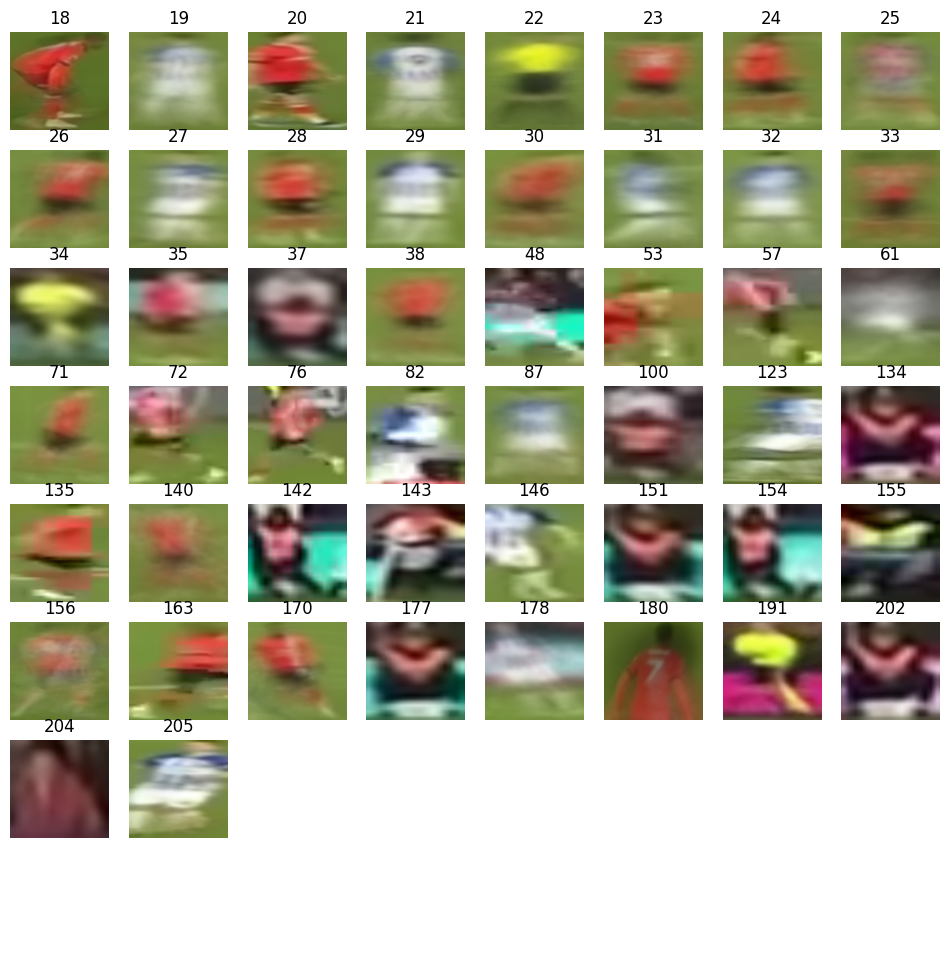

In [40]:
N = math.ceil(math.sqrt(len(blended_crops)))
sv.plot_images_grid(
    blended_crops,
    titles=[str(tracker_id) for tracker_id in tracker_ids],
    grid_size=(N, N)
)

## Prompt GPT-4 Vision

In [43]:
PROMPT = (
    "Identify the team of the marked individual in the composite image: "
    "These images are composite and may not have a distinct human shape. "
    "However, since the color information in the images approximates the color of the person's uniform, "
    "team information is determined from these color information. "
    "The `options are `orange` or `white`. If the individual in the marked composite image does not belong to either team. "
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "If it is very difficult to determine the classification, please classify based on the color information near the center as much as possible "
    "Coaches and fans should not be considered as team members. "
    "Provide the results in JSON format. The output should include key-value pairs, each representing a bounding box. "
    "Format the output like this: {'0': 'color_1', '1': 'color_2', ...}, "
    "where 'color_1', 'color_2', ... are to be replaced with 'orange', 'white', or 'none', as applicable. "
    "Use double quotes to enclose property names. "
    "IMPORTANTLY, do not surround the result with punctuation marks (`). "
    "notalk;justgo"
)

batch_size = 5
crop_batches = list(chunk_list(blended_crops, batch_size))
merged_response = {}

for i, batch in tqdm(enumerate(crop_batches)):
    start_index = i * batch_size
    response = prompt_image(api_key=OPENAI_API_KEY, images=batch, prompt=PROMPT)
    try:
        response_dict = json.loads(response)
        for key, value in response_dict.items():
            merged_response[str(int(key) + start_index)] = value
    except json.JSONDecodeError:
        print(f"Invalid JSON received as response: {response}")

0it [00:00, ?it/s]

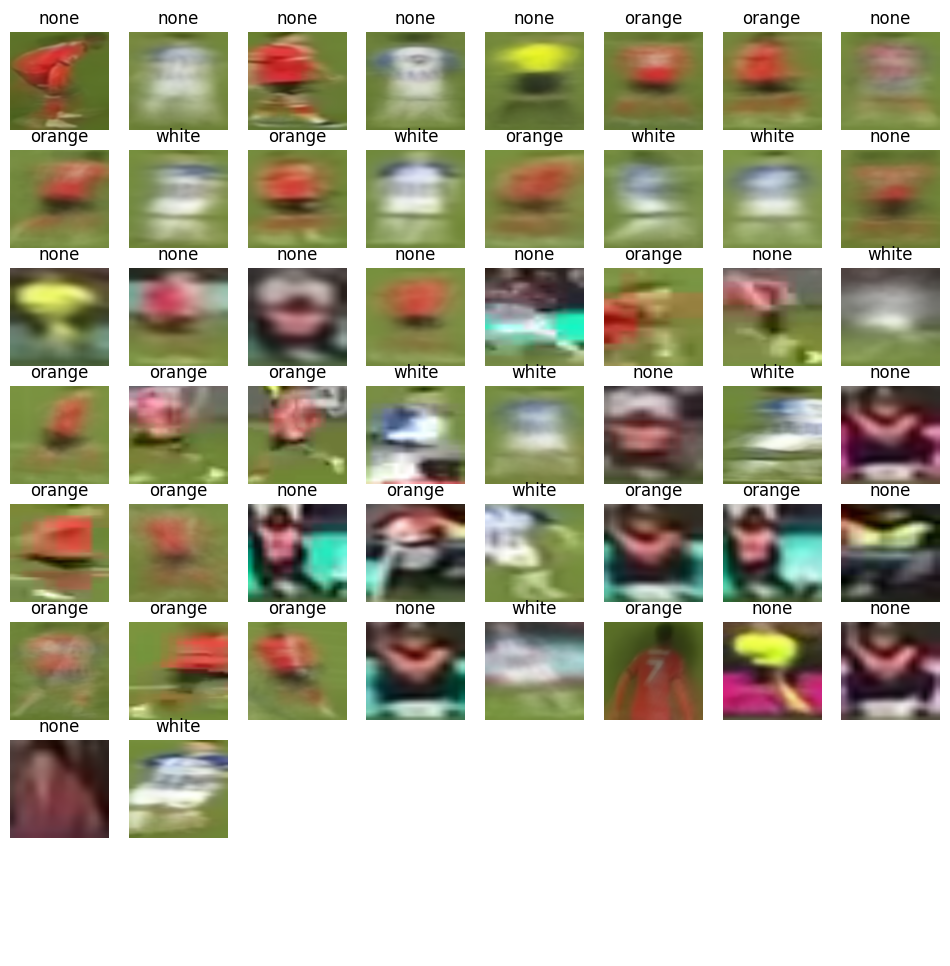

In [44]:
N = math.ceil(math.sqrt(len(blended_crops)))
sv.plot_images_grid(blended_crops, titles=list(merged_response.values()), grid_size=(N, N))

In [45]:
video_info = sv.VideoInfo.from_video_path(single_video_path)

with sv.VideoSink(target_path='raw-tracking.mp4', video_info=video_info) as sink:
    for frame, detections in zip(frames_buffer, detections_buffer):
        annotated_frame = annotate_result(image=frame, detections=detections)
        sink.write_frame(frame=annotated_frame)

<ipython-input-22-7f4890e38509>:76: DeprecationWarning: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.BLACK` instead.
  text_color=sv.Color.black(),


In [46]:
mapping_dict = {
    tracker_ids[int(index)]: CLASSES.index(class_name)
    for index, class_name
    in merged_response.items()
}

vectorized_map = np.vectorize(lambda x: mapping_dict.get(x, -1))

In [47]:
for detections in detections_buffer:
    detections.class_id = vectorized_map(detections.tracker_id)

In [48]:
video_info = sv.VideoInfo.from_video_path(single_video_path)

with sv.VideoSink(target_path='result.mp4', video_info=video_info) as sink:
    for frame, detections in zip(frames_buffer, detections_buffer):
        annotated_frame = annotate_result(image=frame, detections=detections)
        sink.write_frame(frame=annotated_frame)

<ipython-input-22-7f4890e38509>:76: DeprecationWarning: black is deprecated: `Color.black()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.BLACK` instead.
  text_color=sv.Color.black(),
